In [1]:
!pip install numpy
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### AIMD Simulation with Non-linear Alpha Parameters, also known as a non-linear additive increase of window size

- In standard AIMD, the fixed α=1α=1 and β=0.5β=0.5 ensure fairness and stability among competing TCP flows sharing a bottleneck link.

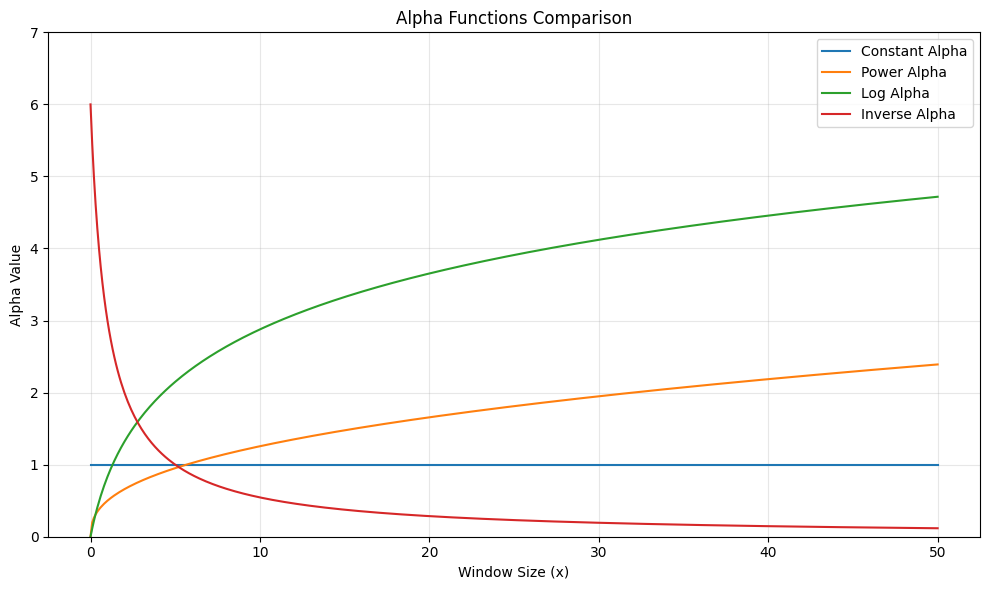

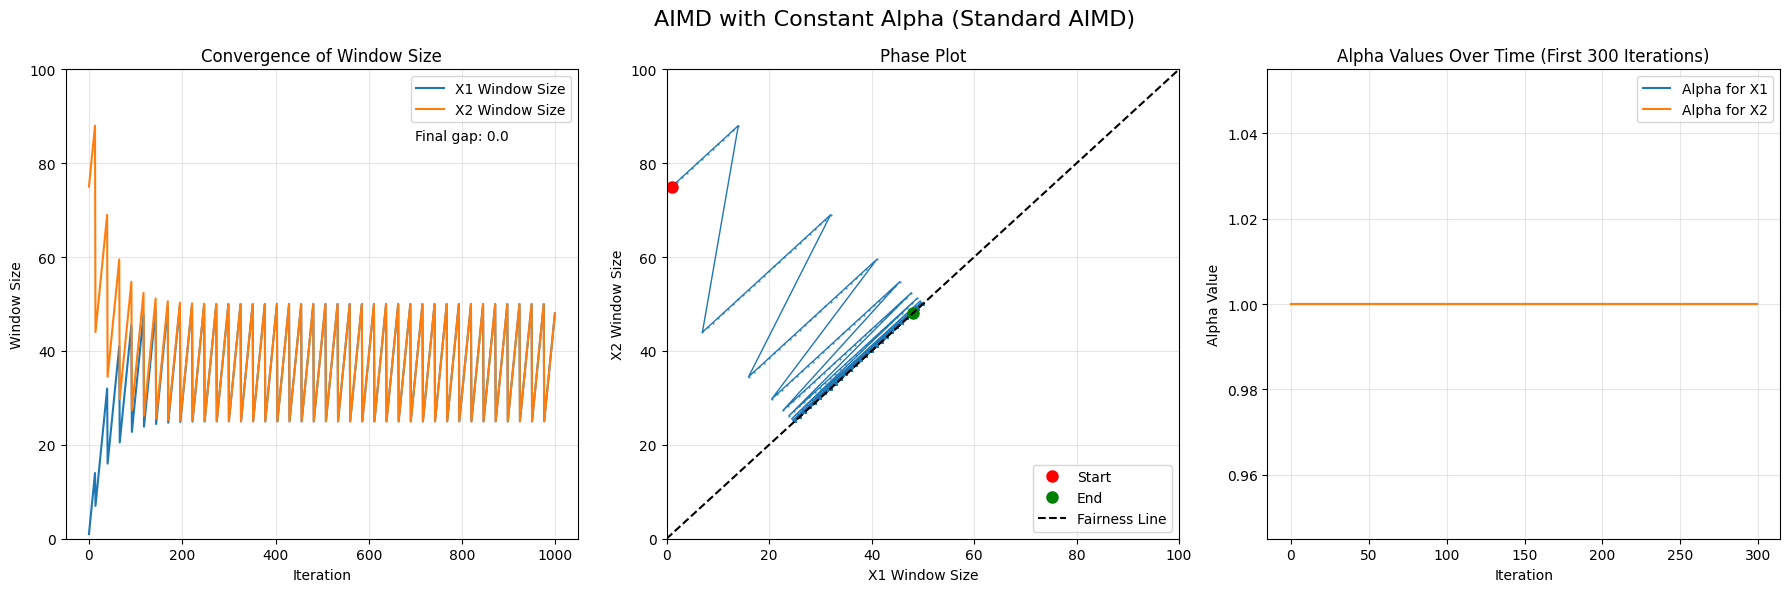

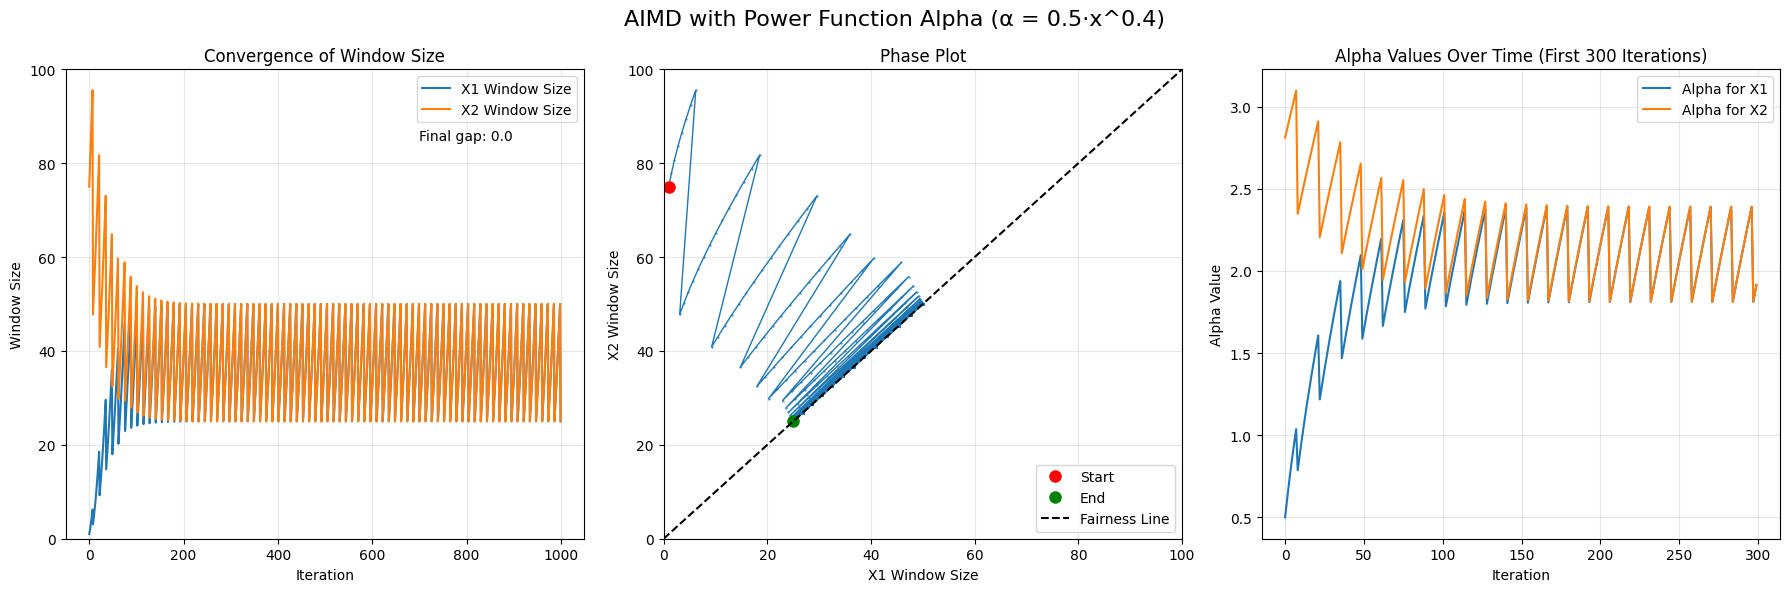

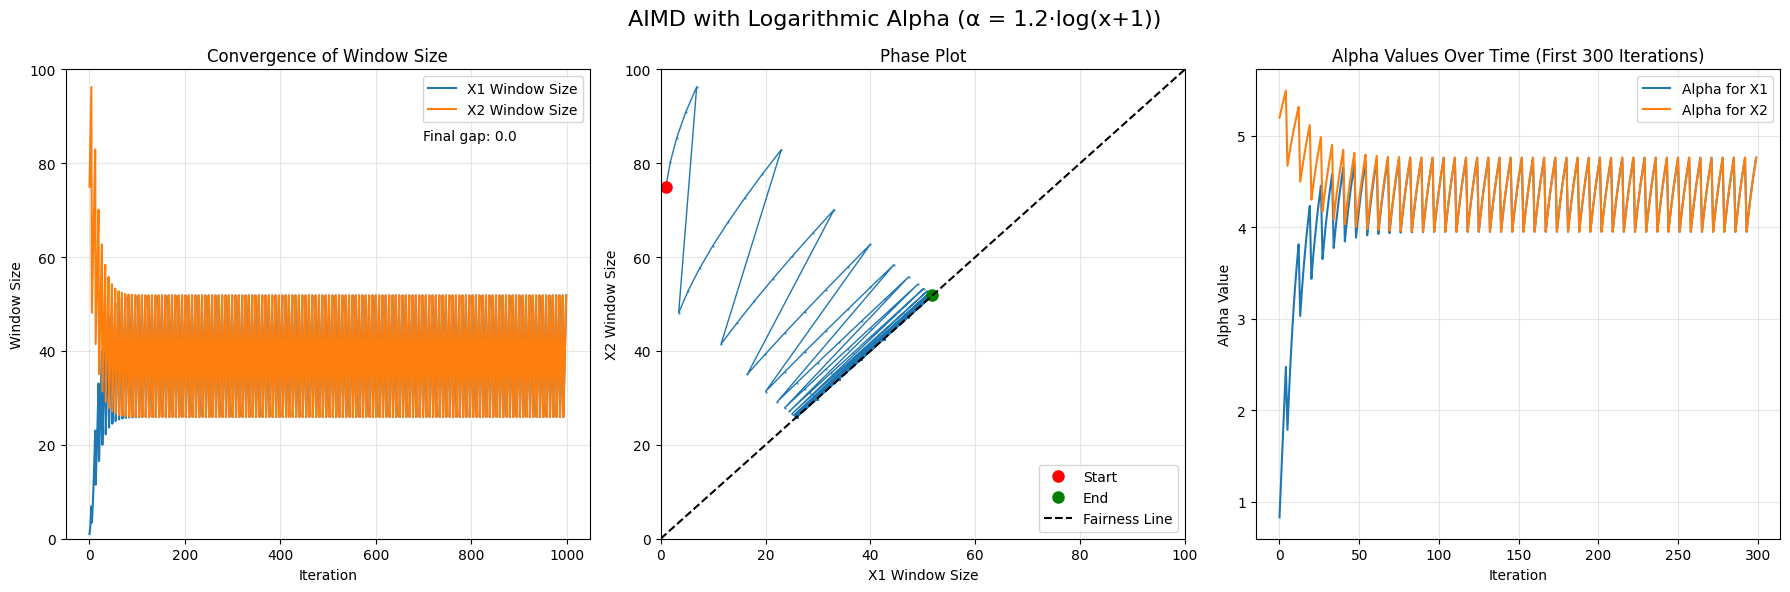

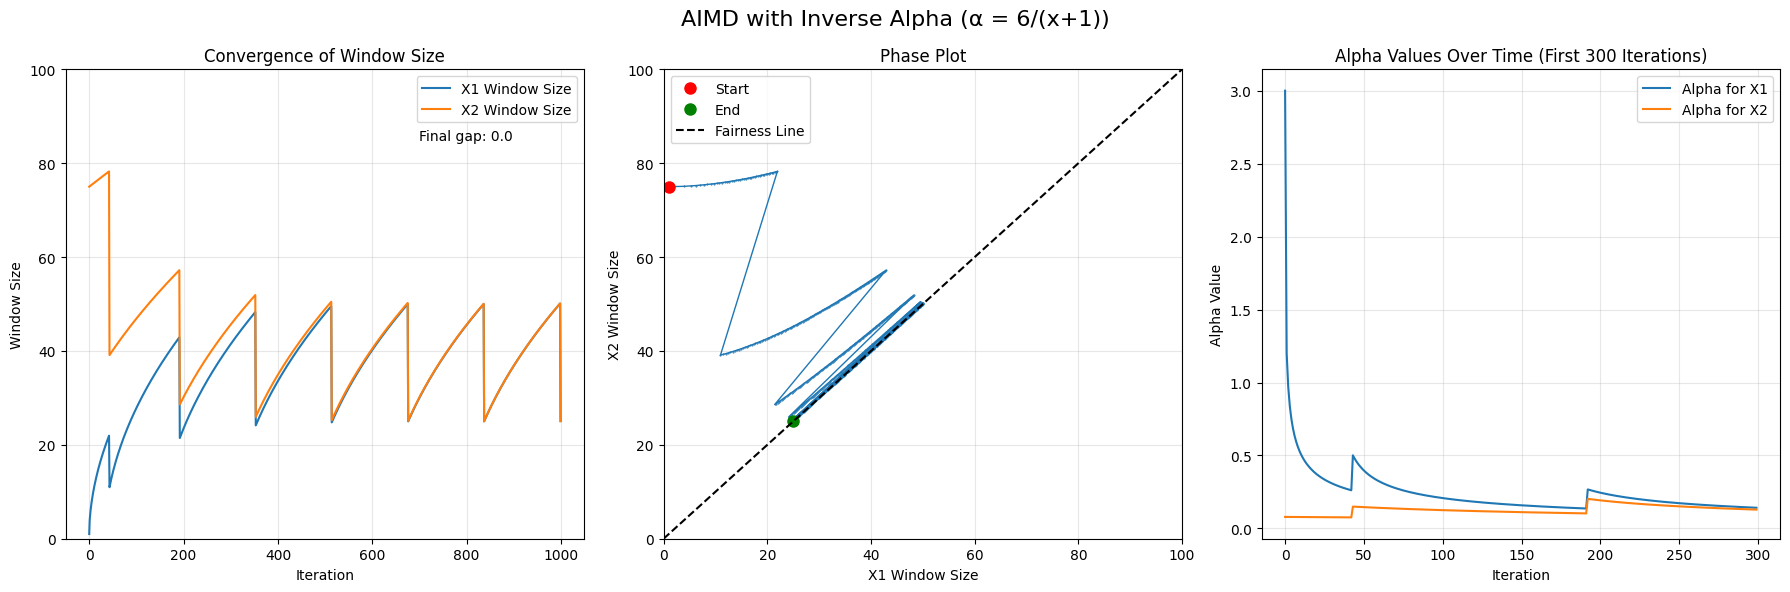

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
ITERATION = 1000  # Maximum number of iterations for the simulation, set at 1000 for better visualisation
CAPACITY = 100    # Capacity limit for the sum of x1 and x2
BETA = 0.5        # Multiplicative decrease parameter (exponent)

# Different additive increase behaviours, by changing the alpha paramaters (linear/non-linear)
def constant_alpha(x):
    return 1.0  # Standard AIMD with constant alpha

# For power alpha, log alpha and inverse alpha can experiment with different values
def power_alpha(x):
    return 0.5 * (x ** 0.4) 

def log_alpha(x):
    return 1.2 * np.log(x + 1)  

def inverse_alpha(x):
    return 6.0 / (x + 1)  

# Function to visualize the alpha functions themselves
def plot_alpha_functions():
    x = np.linspace(0, 50, 500)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, [constant_alpha(xi) for xi in x], label='Constant Alpha')
    plt.plot(x, [power_alpha(xi) for xi in x], label='Power Alpha')
    plt.plot(x, [log_alpha(xi) for xi in x], label='Log Alpha')
    plt.plot(x, [inverse_alpha(xi) for xi in x], label='Inverse Alpha')
    
    plt.xlabel('Window Size (x)')
    plt.ylabel('Alpha Value')
    plt.title('Alpha Functions Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 7)
    plt.tight_layout()
    plt.show()

# Function to create and run simulation with specific alpha function
def run_aimd_simulation(alpha_function, label):
    # Initialise arrays to store values
    x1_values = np.zeros(ITERATION)
    x2_values = np.zeros(ITERATION)
    alpha1_values = np.zeros(ITERATION)
    alpha2_values = np.zeros(ITERATION)
   
    # Initial conditions - starting with different values
    x1 = 1
    x2 = 75  # Start with a larger difference to easily show convergence
   
    # Run the AIMD simulation
    for i in range(ITERATION):
        # Calculate alpha values based on the current window sizes
        alpha1 = alpha_function(x1)
        alpha2 = alpha_function(x2)
       
        # Store current values
        x1_values[i] = x1
        x2_values[i] = x2
        alpha1_values[i] = alpha1
        alpha2_values[i] = alpha2
       
        # Check if total exceeds capacity
        if (x1 + x2 > CAPACITY):
            # Multiplicative decrease when capacity is exceeded
            x1 = x1 * BETA
            x2 = x2 * BETA
        else:
            # Additive increase using the calculated alpha values
            x1 = x1 + alpha1
            x2 = x2 + alpha2
   
    return x1_values, x2_values, alpha1_values, alpha2_values

# First, visualise how the alpha functions behave
plot_alpha_functions()

# Define the alpha functions to compare
functions = [
    (constant_alpha, "Constant Alpha (Standard AIMD)"),
    (power_alpha, "Power Function Alpha (α = 0.5·x^0.4)"),
    (log_alpha, "Logarithmic Alpha (α = 1.2·log(x+1))"),
    (inverse_alpha, "Inverse Alpha (α = 6/(x+1))")
]

# Create plots for each alpha function
for alpha_func, label in functions:
    x1_values, x2_values, alpha1_values, alpha2_values = run_aimd_simulation(alpha_func, label)
   
    # Create a figure with 3 subplots to better illustrate behaviour
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'AIMD with {label}', fontsize=16)
    iterations = np.arange(ITERATION)
   
    # Time series plot of x1 and x2
    ax1.plot(iterations, x1_values, label='X1 Window Size', linewidth=1.5)
    ax1.plot(iterations, x2_values, label='X2 Window Size', linewidth=1.5)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Window Size')
    ax1.set_title('Convergence of Window Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
   
    # Phase plot (x1 vs x2)
    ax2.plot(x1_values, x2_values, marker=".", linewidth=1, markersize=1)
    ax2.plot(x1_values[0], x2_values[0], 'ro', markersize=8, label='Start')
    ax2.plot(x1_values[-1], x2_values[-1], 'go', markersize=8, label='End')
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0, 100])
    ax2.set_xlabel('X1 Window Size')
    ax2.set_ylabel('X2 Window Size')
    ax2.axline((0, 0), slope=1, label="Fairness Line", color="black", linestyle='--', linewidth=1.5)
    ax2.set_title('Phase Plot')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # New subplot to show alpha values over time
    ax3.plot(iterations[:300], alpha1_values[:300], label='Alpha for X1', linewidth=1.5)
    ax3.plot(iterations[:300], alpha2_values[:300], label='Alpha for X2', linewidth=1.5)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Alpha Value')
    ax3.set_title('Alpha Values Over Time (First 300 Iterations)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
   
    # Add final gap annotation
    final_gap = abs(x1_values[-1] - x2_values[-1])
    ax1.text(ITERATION*0.7, 85, f"Final gap: {final_gap:.1f}", fontsize=10)
   
    plt.tight_layout()
    plt.show()

### AIMD Simulation with HighSpeed TCP Beta Parameter

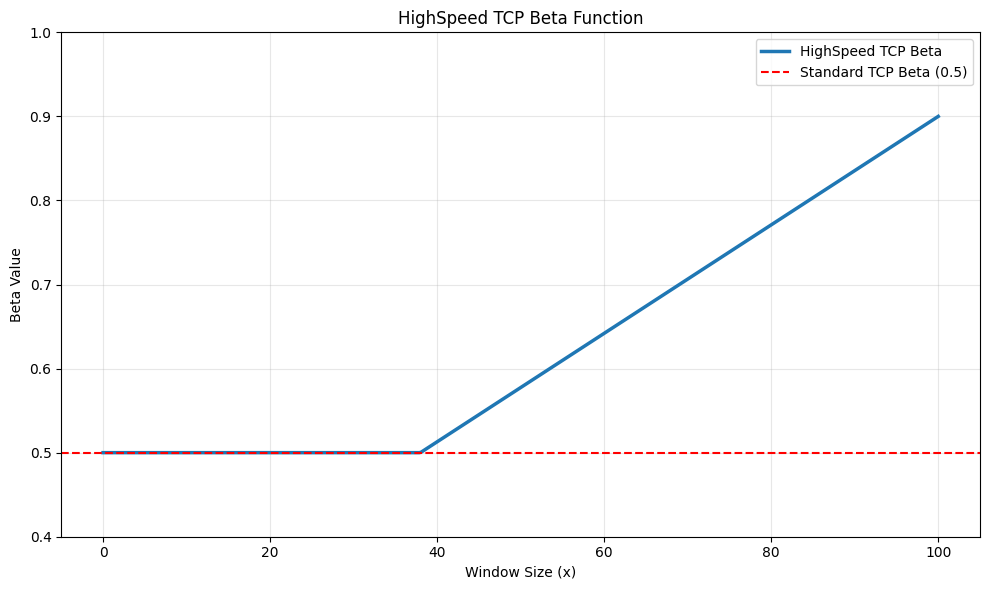

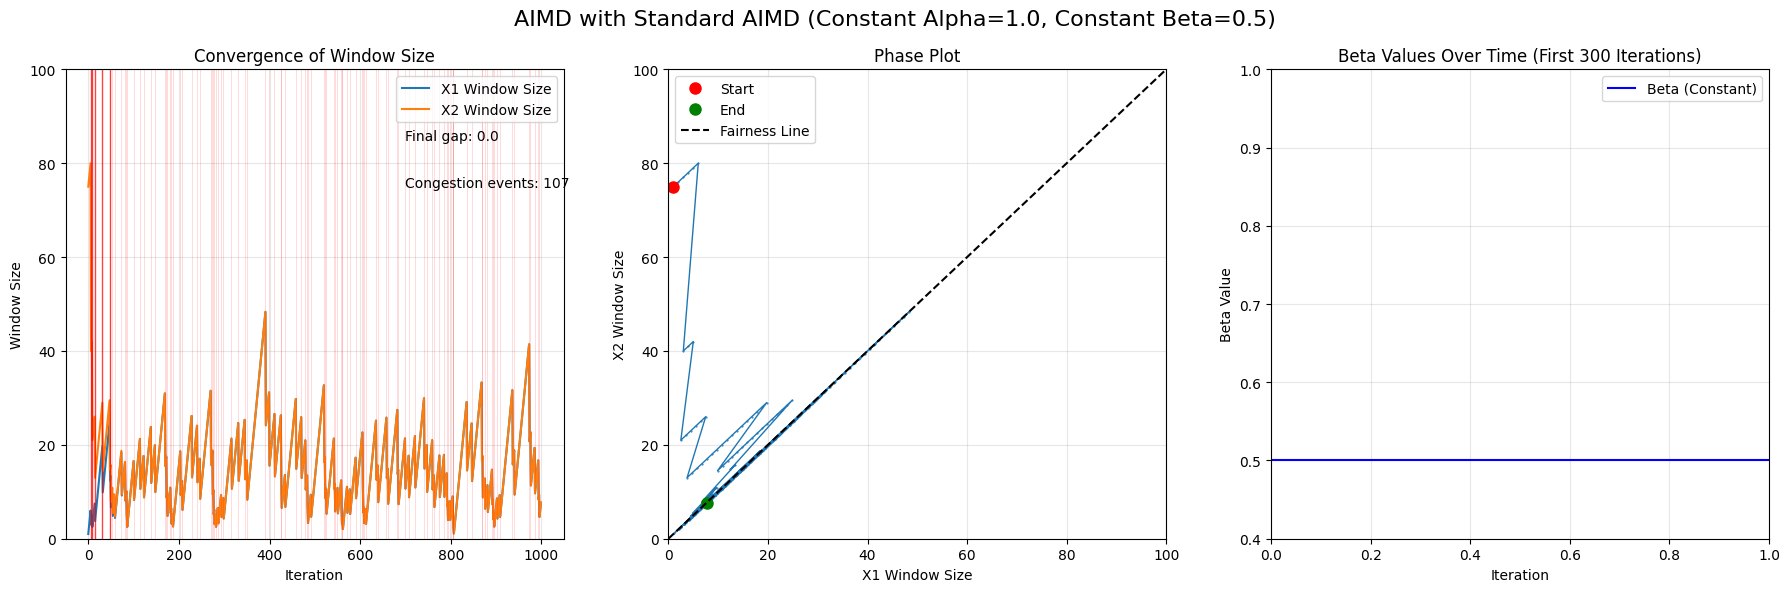

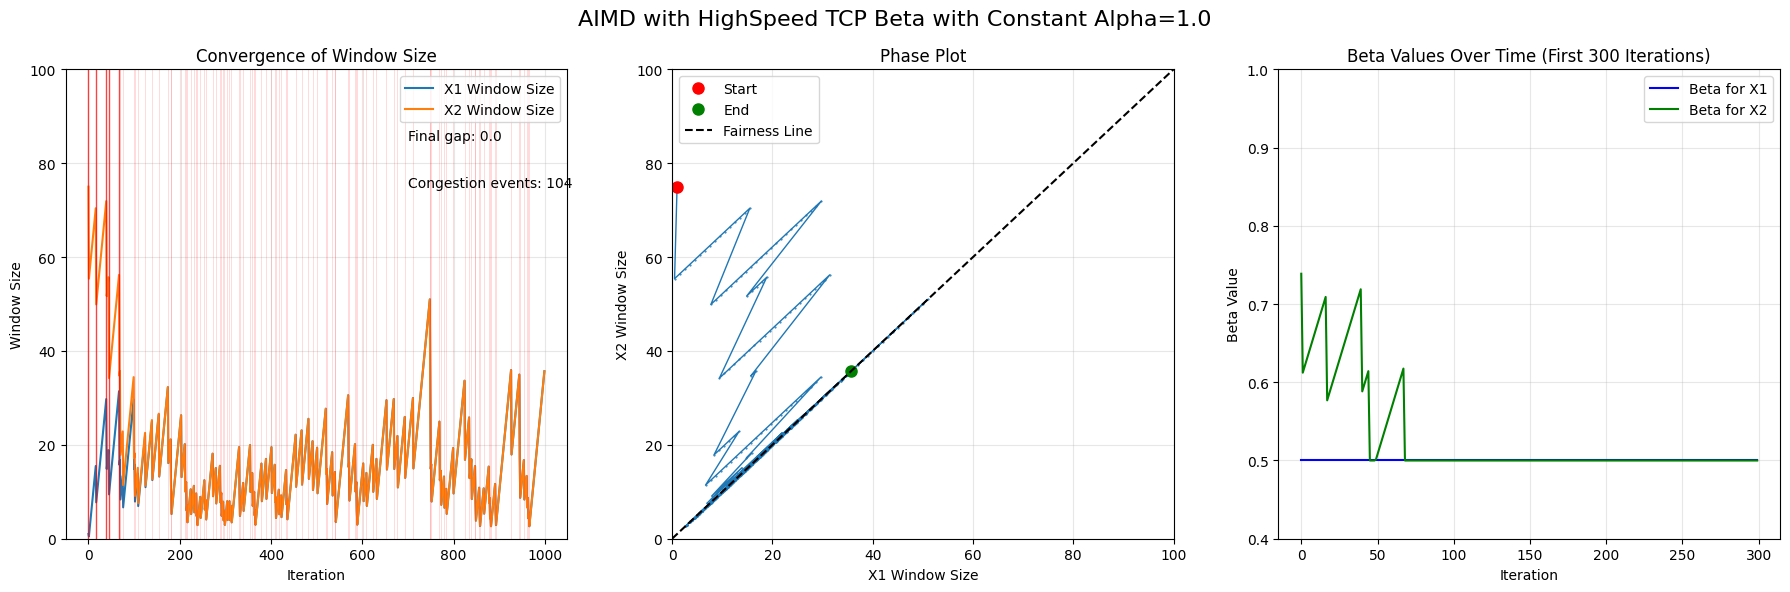

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Simulation parameters
ITERATION = 1000      
CAPACITY = 100        
BASE_ALPHA = 1.0      
BASE_BETA = 0.5       # Base multiplicative decrease parameter (standard TCP)
CONGESTION_PROB = 0.1 # Probability of random congestion events

# HighSpeed TCP beta function - varies with window size
def highspeed_beta(w):
    """
    HighSpeed TCP beta calculation - decreases less aggressively for larger windows
    For small windows, behaves like standard TCP (beta = 0.5)
    For large windows, beta ranges between 0.5 and 0.9
    """
    if w <= 38:  # Standard TCP behavior for small windows
        return 0.5
    else:
        # HighSpeed TCP formula - beta increases with window size
        return min(0.9, 0.5 + 0.4 * (w - 38) / 62)

# Function to visualise the how beta function behaves over window size
def plot_beta_function():
    x = np.linspace(0, 100, 500)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, [highspeed_beta(xi) for xi in x], label='HighSpeed TCP Beta', linewidth=2.5)
    plt.axhline(y=0.5, color='r', linestyle='--', label='Standard TCP Beta (0.5)')
    
    plt.xlabel('Window Size (x)')
    plt.ylabel('Beta Value')
    plt.title('HighSpeed TCP Beta Function')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.4, 1.0)
    
    plt.tight_layout()
    plt.show()

# Function to create and run simulation with specific beta function
def run_aimd_simulation(use_highspeed_beta, label):
    # Initialise arrays to store values
    x1_values = np.zeros(ITERATION)
    x2_values = np.zeros(ITERATION)
    beta1_values = np.zeros(ITERATION)
    beta2_values = np.zeros(ITERATION)
    congestion_events = []
   
    # Initial conditions - starting with different values
    x1 = 1
    x2 = 75  # Starting with a larger difference to demonstrate convergence to fairness line
   
    # Run the AIMD simulation
    for i in range(ITERATION):
        # Use constant alpha 
        alpha1 = BASE_ALPHA
        alpha2 = BASE_ALPHA
        
        # Calculate beta values - either constant or highspeed
        if use_highspeed_beta:
            beta1 = highspeed_beta(x1)
            beta2 = highspeed_beta(x2)
        else:
            beta1 = BASE_BETA
            beta2 = BASE_BETA
       
        # Store current values
        x1_values[i] = x1
        x2_values[i] = x2
        beta1_values[i] = beta1
        beta2_values[i] = beta2
       
        # Check for congestion events
        # Two types: capacity exceeded or random congestion
        congestion = False
        
        # 1. Capacity exceeded
        if (x1 + x2 > CAPACITY):
            congestion = True
        
        # 2. Random congestion events (to simulate network losses)
        elif random.random() < CONGESTION_PROB:
            congestion = True
            
        if congestion:
            # Record congestion event
            congestion_events.append(i)
            
            # Multiplicative decrease with appropriate beta
            x1 = x1 * beta1
            x2 = x2 * beta2
        else:
            # Additive increase using constant alpha
            x1 = x1 + alpha1
            x2 = x2 + alpha2
   
    return x1_values, x2_values, beta1_values, beta2_values, congestion_events

plot_beta_function()

# Define the two scenarios to compare
function = [
    (False, "Standard AIMD (Constant Alpha=1.0, Constant Beta=0.5)"),
    (True, "HighSpeed TCP Beta with Constant Alpha=1.0")
]

# Create plots for each scenario
for use_highspeed_beta, label in function:
    x1_values, x2_values, beta1_values, beta2_values, congestion_events = run_aimd_simulation(
        use_highspeed_beta, label)
   
    # Create a figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'AIMD with {label}', fontsize=16)
    iterations = np.arange(ITERATION)
   
    # Time series plot of x1 and x2
    ax1.plot(iterations, x1_values, label='X1 Window Size', linewidth=1.5)
    ax1.plot(iterations, x2_values, label='X2 Window Size', linewidth=1.5)
    
    # Mark congestion events (to see better)
    for event in congestion_events:
        ax1.axvline(x=event, color='r', alpha=0.2, linewidth=0.5)
    
    # Highlight the first few congestion events
    for event in congestion_events[:5]:
        ax1.axvline(x=event, color='r', alpha=0.7, linewidth=1)
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Window Size')
    ax1.set_title('Convergence of Window Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
   
    # Phase plot (x1 vs x2)
    ax2.plot(x1_values, x2_values, marker=".", linewidth=1, markersize=1)
    ax2.plot(x1_values[0], x2_values[0], 'ro', markersize=8, label='Start')
    ax2.plot(x1_values[-1], x2_values[-1], 'go', markersize=8, label='End')
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0, 100])
    ax2.set_xlabel('X1 Window Size')
    ax2.set_ylabel('X2 Window Size')
    ax2.axline((0, 0), slope=1, label="Fairness Line", color="black", linestyle='--', linewidth=1.5)
    ax2.set_title('Phase Plot')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot of beta values over time
    if use_highspeed_beta:
        ax3.plot(iterations[:300], beta1_values[:300], label='Beta for X1', linewidth=1.5, color='blue')
        ax3.plot(iterations[:300], beta2_values[:300], label='Beta for X2', linewidth=1.5, color='green')
    else:
        ax3.axhline(y=BASE_BETA, color='blue', linestyle='-', label='Beta (Constant)')
    
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Beta Value')
    ax3.set_title('Beta Values Over Time (First 300 Iterations)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0.4, 1.0])
   
    # Add final gap annotation
    final_gap = abs(x1_values[-1] - x2_values[-1])
    ax1.text(ITERATION*0.7, 85, f"Final gap: {final_gap:.1f}", fontsize=10)
    
    # Add congestion count annotation
    ax1.text(ITERATION*0.7, 75, f"Congestion events: {len(congestion_events)}", fontsize=10)
   
    plt.tight_layout()
    plt.show()

### Enhanced AIMD simulation with non-linear alpha paramters and highspeed TCP beta parameters

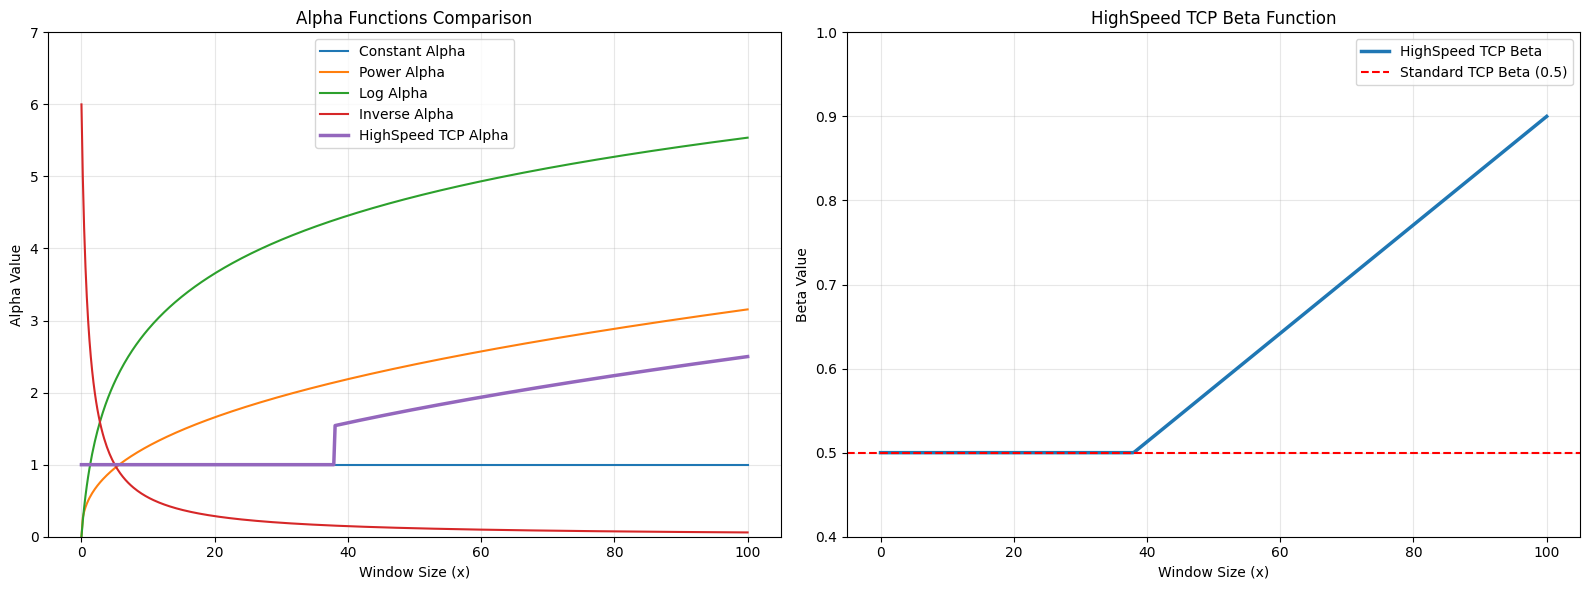

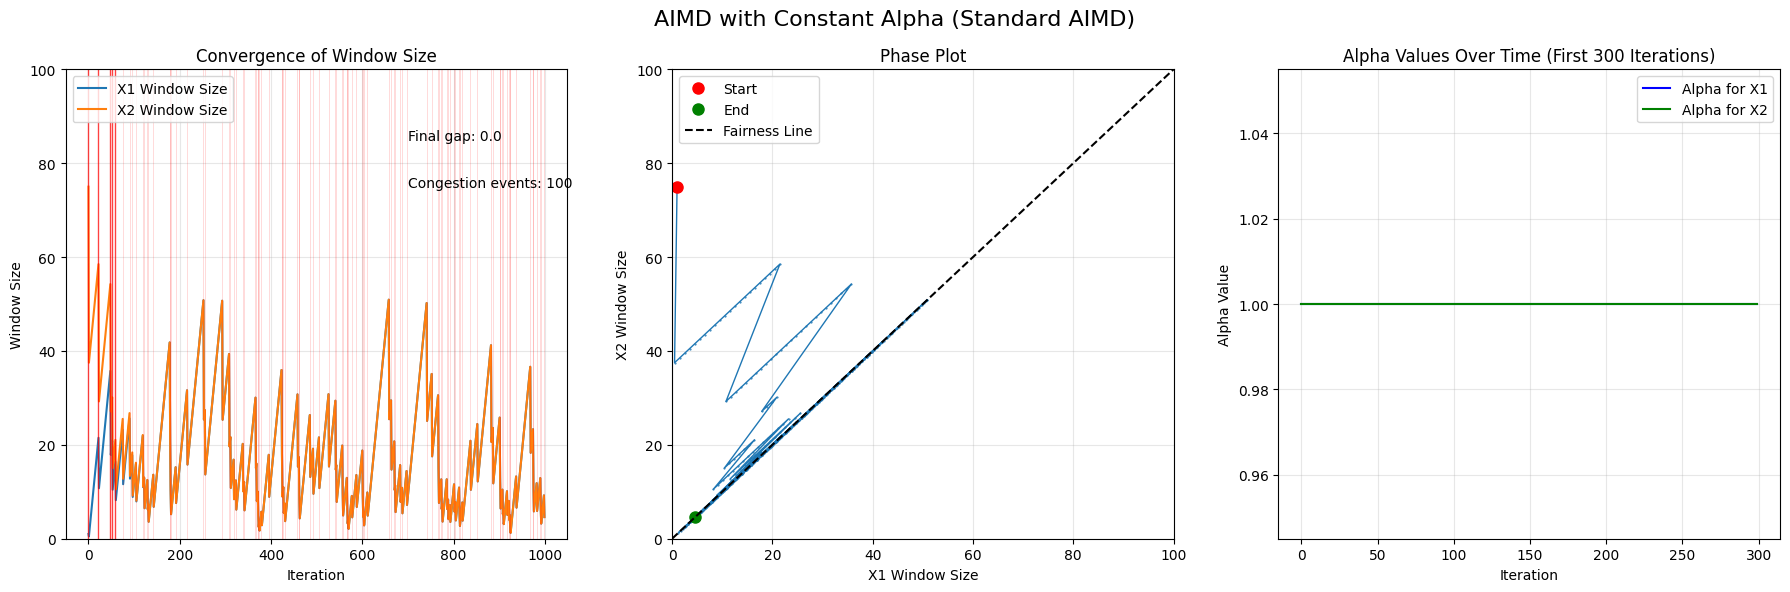

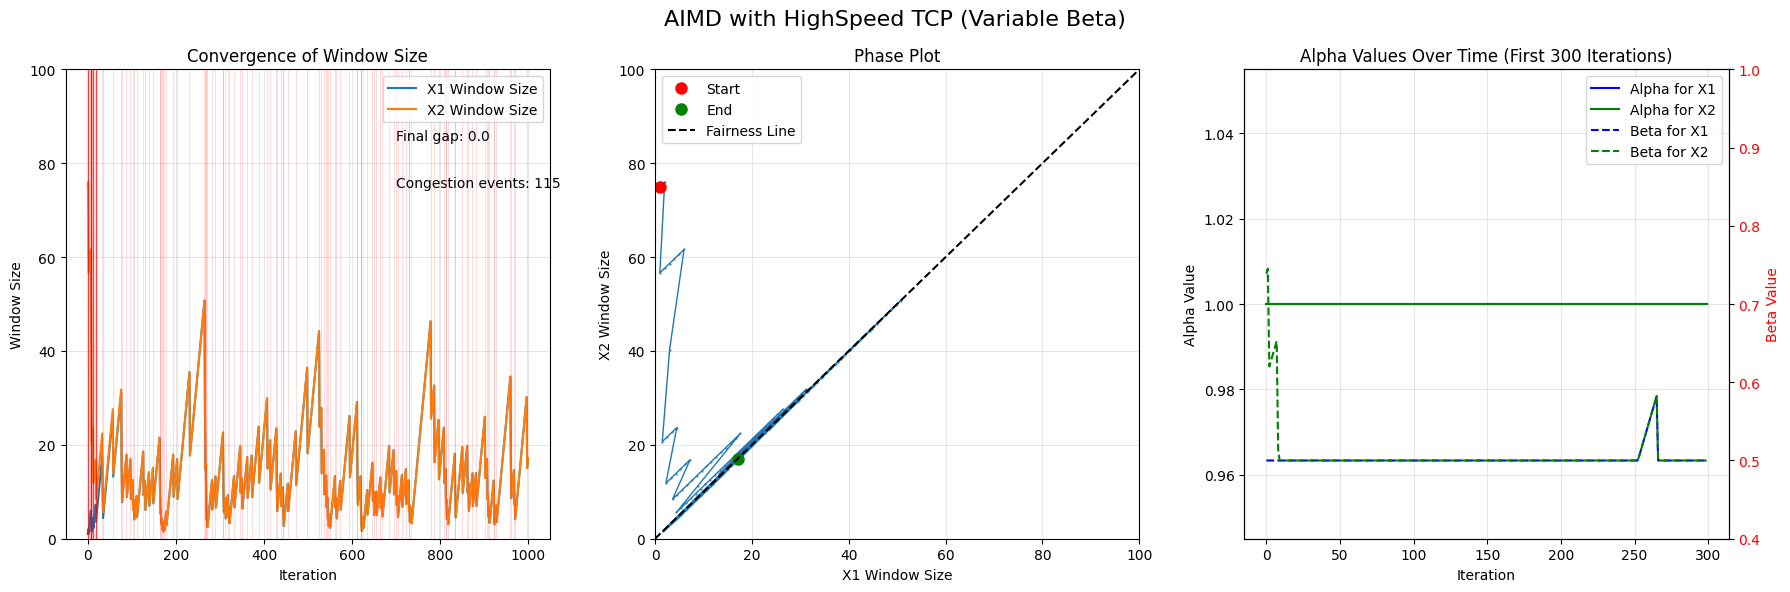

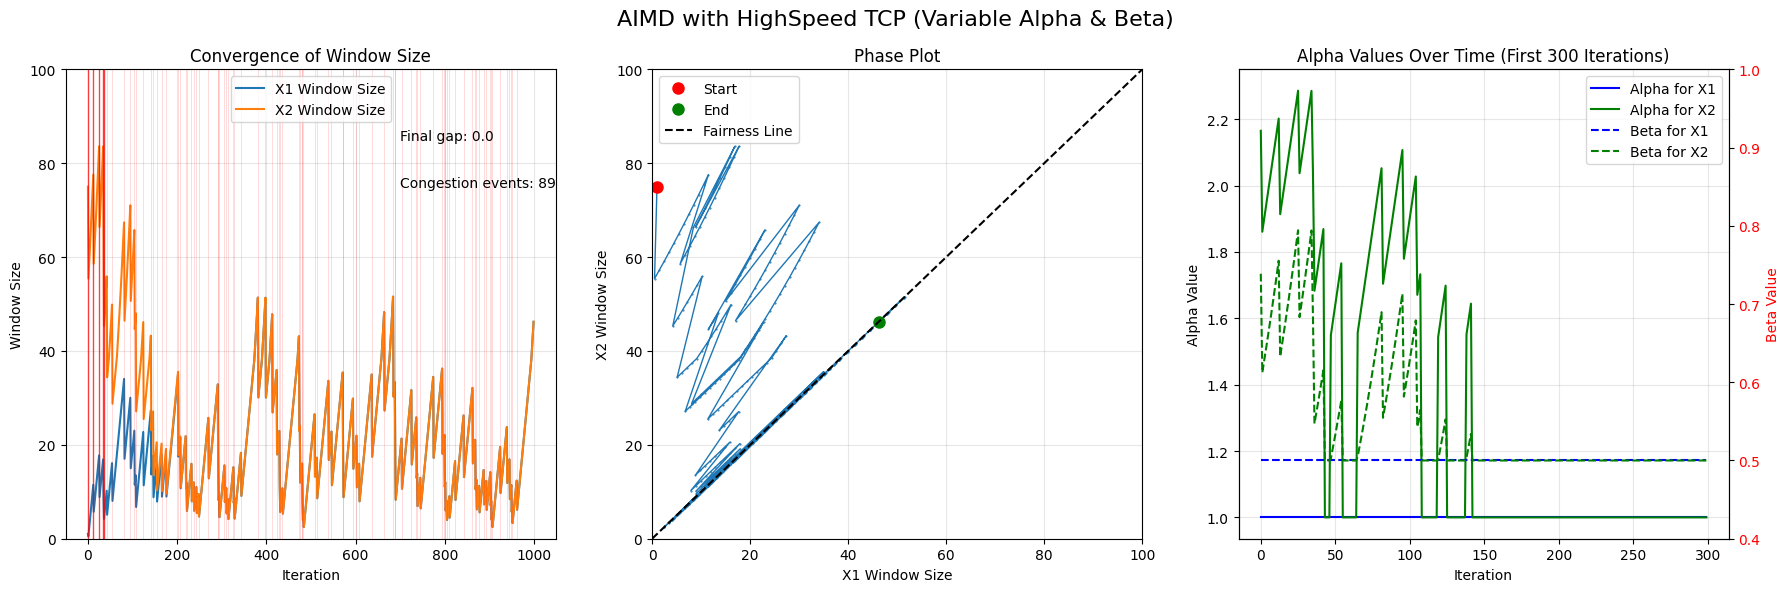

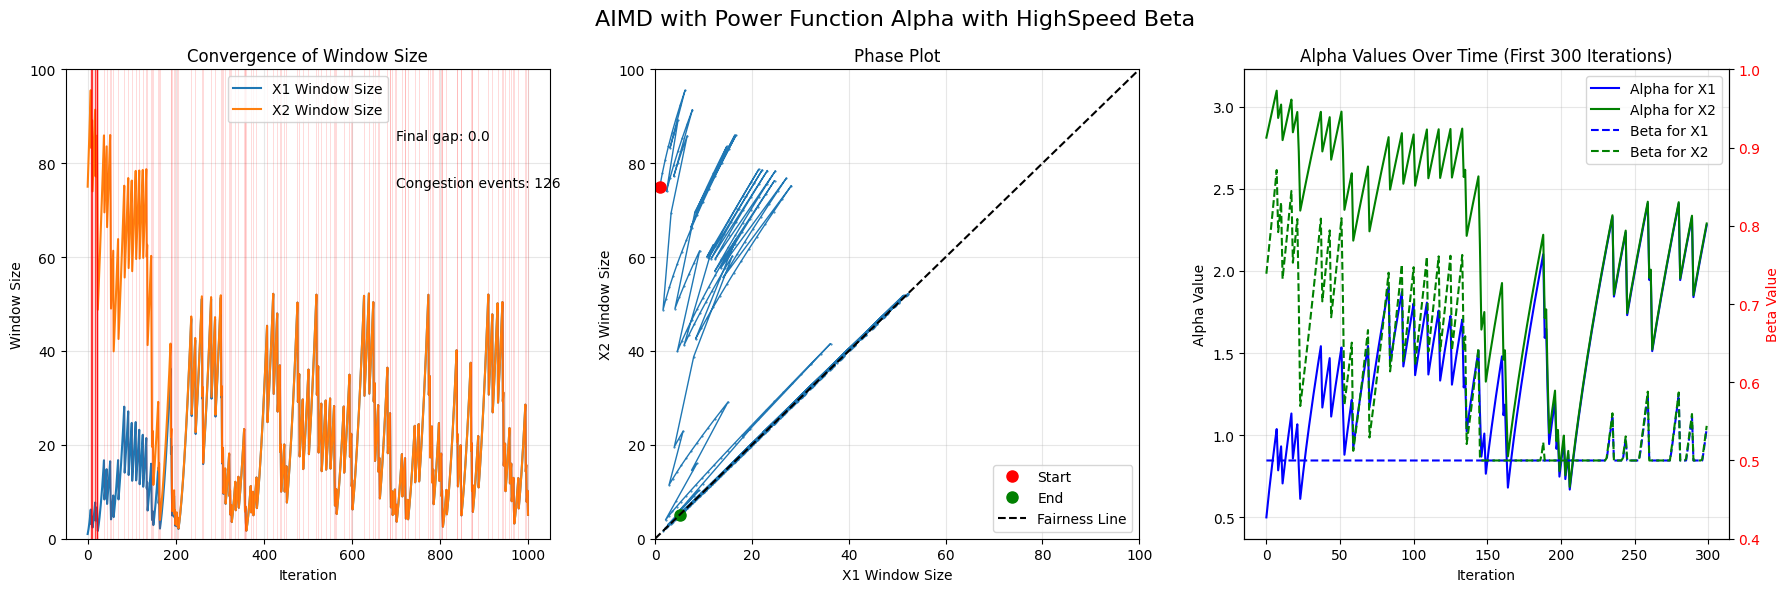

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Simulation parameters
ITERATION = 1000      # Maximum number of iterations for the simulation
CAPACITY = 100        # Capacity limit for the sum of x1 and x2
BASE_BETA = 0.5       # Base multiplicative decrease parameter
CONGESTION_PROB = 0.1 # Probability of random congestion events

# HighSpeed TCP beta function - varies with window size
def highspeed_beta(w):
    """
    HighSpeed TCP beta calculation - decreases less aggressively for larger windows
    For small windows, behaves like standard TCP (beta = 0.5)
    For large windows, beta approaches 0.9
    """
    if w <= 38:  # Standard TCP behavior for small windows
        return 0.5
    else:
        # HighSpeed TCP formula - beta increases with window size
        return min(0.9, 0.5 + 0.4 * (w - 38) / 62)

# HighSpeed TCP alpha function - more aggressive for large windows
def highspeed_alpha(w):
    """
    HighSpeed TCP alpha calculation - increases more aggressively for larger windows
    """
    if w <= 38:  # Standard TCP behavior for small windows
        return 1.0
    else:
        # Simplified HighSpeed TCP formula
        return 0.25 * np.sqrt(w)

# Define enhanced alpha functions to compare with HighSpeed TCP
def constant_alpha(x):
    return 1.0  # Standard AIMD with constant alpha

def power_alpha(x):
    return 0.5 * (x ** 0.4)  # Power function alpha

def log_alpha(x):
    return 1.2 * np.log(x + 1)  # Logarithmic alpha

def inverse_alpha(x):
    return 6.0 / (x + 1)  # Inverse function alpha

# Function to visualize the alpha and beta functions
def plot_alpha_beta_functions():
    x = np.linspace(0, 100, 500)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Alpha functions
    ax1.plot(x, [constant_alpha(xi) for xi in x], label='Constant Alpha')
    ax1.plot(x, [power_alpha(xi) for xi in x], label='Power Alpha')
    ax1.plot(x, [log_alpha(xi) for xi in x], label='Log Alpha')
    ax1.plot(x, [inverse_alpha(xi) for xi in x], label='Inverse Alpha')
    ax1.plot(x, [highspeed_alpha(xi) for xi in x], label='HighSpeed TCP Alpha', linewidth=2.5)
    
    ax1.set_xlabel('Window Size (x)')
    ax1.set_ylabel('Alpha Value')
    ax1.set_title('Alpha Functions Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 7)
    
    # Beta function for HighSpeed TCP
    ax2.plot(x, [highspeed_beta(xi) for xi in x], label='HighSpeed TCP Beta', linewidth=2.5)
    ax2.axhline(y=0.5, color='r', linestyle='--', label='Standard TCP Beta (0.5)')
    
    ax2.set_xlabel('Window Size (x)')
    ax2.set_ylabel('Beta Value')
    ax2.set_title('HighSpeed TCP Beta Function')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0.4, 1.0)
    
    plt.tight_layout()
    plt.show()

# Function to create and run simulation with specific alpha function
def run_aimd_simulation(alpha_function, label, use_highspeed_beta=False):
    # Initialize arrays to store values
    x1_values = np.zeros(ITERATION)
    x2_values = np.zeros(ITERATION)
    alpha1_values = np.zeros(ITERATION)
    alpha2_values = np.zeros(ITERATION)
    beta1_values = np.zeros(ITERATION)
    beta2_values = np.zeros(ITERATION)
    congestion_events = []
   
    # Initial conditions - starting with different values
    x1 = 1
    x2 = 75  # Starting with a larger difference to demonstrate convergence
   
    # Run the AIMD simulation
    for i in range(ITERATION):
        # Calculate alpha values based on the current window sizes
        alpha1 = alpha_function(x1)
        alpha2 = alpha_function(x2)
        
        # Calculate beta values if using HighSpeed TCP
        if use_highspeed_beta:
            beta1 = highspeed_beta(x1)
            beta2 = highspeed_beta(x2)
        else:
            beta1 = BASE_BETA
            beta2 = BASE_BETA
       
        # Store current values
        x1_values[i] = x1
        x2_values[i] = x2
        alpha1_values[i] = alpha1
        alpha2_values[i] = alpha2
        beta1_values[i] = beta1
        beta2_values[i] = beta2
       
        # Check for congestion events
        # Two types: capacity exceeded or random congestion
        congestion = False
        
        # 1. Capacity exceeded
        if (x1 + x2 > CAPACITY):
            congestion = True
        
        # 2. Random congestion events (to simulate network losses)
        elif random.random() < CONGESTION_PROB:
            congestion = True
            
        if congestion:
            # Record congestion event
            congestion_events.append(i)
            
            # Multiplicative decrease with appropriate beta
            x1 = x1 * beta1
            x2 = x2 * beta2
        else:
            # Additive increase using the calculated alpha values
            x1 = x1 + alpha1
            x2 = x2 + alpha2
   
    return x1_values, x2_values, alpha1_values, alpha2_values, beta1_values, beta2_values, congestion_events

# First, visualize how the alpha and beta functions behave
plot_alpha_beta_functions()

# Define functions with enhanced descriptions
functions = [
    (constant_alpha, "Constant Alpha (Standard AIMD)", False),
    (constant_alpha, "HighSpeed TCP (Variable Beta)", True),
    (highspeed_alpha, "HighSpeed TCP (Variable Alpha & Beta)", True),
    (power_alpha, "Power Function Alpha with HighSpeed Beta", True)
]

# Create plots for each alpha function
for alpha_func, label, use_highspeed_beta in functions:
    x1_values, x2_values, alpha1_values, alpha2_values, beta1_values, beta2_values, congestion_events = run_aimd_simulation(
        alpha_func, label, use_highspeed_beta)
   
    # Create a figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'AIMD with {label}', fontsize=16)
    iterations = np.arange(ITERATION)
   
    # Time series plot of x1 and x2
    ax1.plot(iterations, x1_values, label='X1 Window Size', linewidth=1.5)
    ax1.plot(iterations, x2_values, label='X2 Window Size', linewidth=1.5)
    
    # Mark congestion events
    for event in congestion_events:
        ax1.axvline(x=event, color='r', alpha=0.2, linewidth=0.5)
    
    # Highlight the first few congestion events
    for event in congestion_events[:5]:
        ax1.axvline(x=event, color='r', alpha=0.7, linewidth=1)
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Window Size')
    ax1.set_title('Convergence of Window Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
   
    # Phase plot (x1 vs x2)
    ax2.plot(x1_values, x2_values, marker=".", linewidth=1, markersize=1)
    ax2.plot(x1_values[0], x2_values[0], 'ro', markersize=8, label='Start')
    ax2.plot(x1_values[-1], x2_values[-1], 'go', markersize=8, label='End')
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0, 100])
    ax2.set_xlabel('X1 Window Size')
    ax2.set_ylabel('X2 Window Size')
    ax2.axline((0, 0), slope=1, label="Fairness Line", color="black", linestyle='--', linewidth=1.5)
    ax2.set_title('Phase Plot')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # New subplot to show alpha/beta values over time
    ax3.plot(iterations[:300], alpha1_values[:300], label='Alpha for X1', linewidth=1.5, color='blue')
    ax3.plot(iterations[:300], alpha2_values[:300], label='Alpha for X2', linewidth=1.5, color='green')
    
    if use_highspeed_beta:
        # Add beta values on second y-axis
        ax3_twin = ax3.twinx()
        ax3_twin.plot(iterations[:300], beta1_values[:300], label='Beta for X1', linewidth=1.5, color='blue', linestyle='--')
        ax3_twin.plot(iterations[:300], beta2_values[:300], label='Beta for X2', linewidth=1.5, color='green', linestyle='--')
        ax3_twin.set_ylabel('Beta Value', color='red')
        ax3_twin.tick_params(axis='y', labelcolor='red')
        ax3_twin.set_ylim([0.4, 1.0])
        
        # Combine legends
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    else:
        ax3.legend()
    
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Alpha Value')
    ax3.set_title('Alpha Values Over Time (First 300 Iterations)')
    ax3.grid(True, alpha=0.3)
   
    # Add final gap annotation
    final_gap = abs(x1_values[-1] - x2_values[-1])
    ax1.text(ITERATION*0.7, 85, f"Final gap: {final_gap:.1f}", fontsize=10)
    
    # Add congestion count annotation
    ax1.text(ITERATION*0.7, 75, f"Congestion events: {len(congestion_events)}", fontsize=10)
   
    plt.tight_layout()
    plt.show()